## Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'with device:', device)

Using PyTorch version: 2.1.0+cu118 with device: cuda


## Prepare Data

### Define constants that will be used throughout modeling process

In [28]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 1000
k = 1
lr = 5e-4

### Create boundary points

Text(0, 0.5, 'Y')

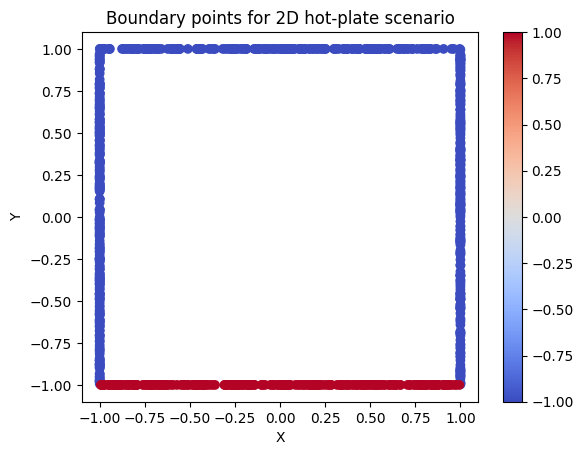

In [29]:
border_x = np.random.choice(border_coords, num_points//4)
dist_y = np.random.uniform(border_coords[0], border_coords[1], num_points//4)

border_y = np.random.choice(border_coords, num_points//4)
dist_x = np.random.uniform(border_coords[0], border_coords[1], num_points//4)

final_lr = np.hstack((border_x, dist_y))
final_tb = np.hstack((dist_x, border_y))

boundary_locs = np.vstack((final_lr, final_tb)).T
boundary_temps = np.where(boundary_locs[:,1] == border_coords[0], temp_range[1], temp_range[0]).reshape(num_points//2, 1)
boundary = np.hstack((boundary_locs, boundary_temps))

plt.scatter(boundary[:,0].T, boundary[:,1].T, c=boundary[:,2].T, cmap="coolwarm")
plt.colorbar()
plt.title("Boundary points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

### Create collocation points

Text(0, 0.5, 'Y')

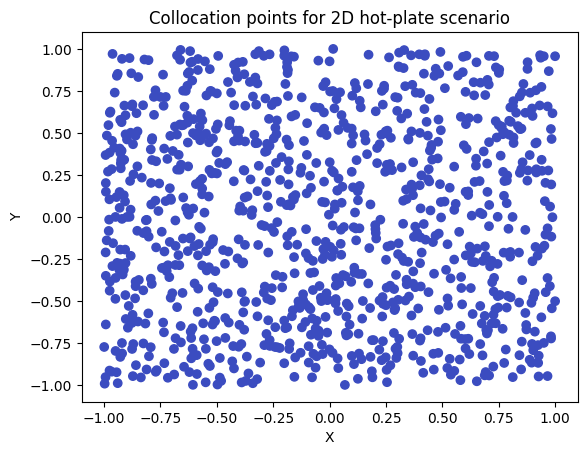

In [30]:
diff_locs = np.random.uniform(border_coords[0], border_coords[1], size=(num_points//2, 2))
diff_temp = np.full((num_points//2, 1), temp_range[0])

collocation = np.hstack((diff_locs, diff_temp))

plt.scatter(collocation[:,0].T, collocation[:,1].T, c=collocation[:,2].T, cmap="coolwarm")
plt.title("Collocation points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

### Plot combined boundary and collocation points

Text(0, 0.5, 'Y')

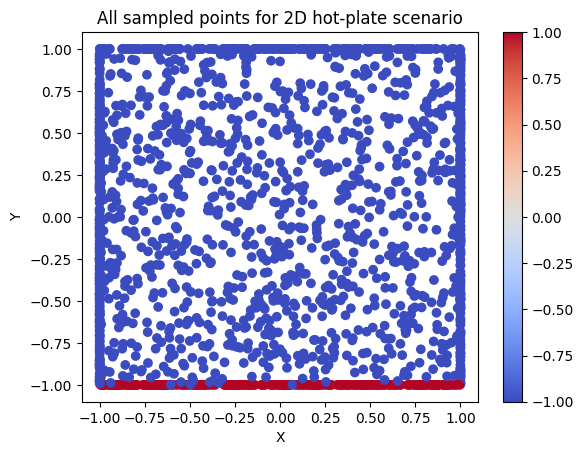

In [31]:
combined = np.vstack((boundary, collocation))

plt.scatter(combined[:,0].T, combined[:,1].T, c=combined[:,2].T, cmap="coolwarm")
plt.colorbar()
plt.title("All sampled points for 2D hot-plate scenario")
plt.xlabel("X")
plt.ylabel("Y")

## Define Model

In [32]:
class PINN2D(nn.Module):
  """
  class for 2-dimensional PINN
  """
  def __init__(self, in_dim=2):
    super().__init__()
    self.linear_1 = nn.Linear(in_dim, 20)
    self.activation_1 = nn.Tanh()
    self.linear_2 = nn.Linear(20, 20)
    self.activation_2 = nn.Tanh()
    self.linear_3 = nn.Linear(20, 20)
    self.activation_3 = nn.Tanh()
    self.linear_4 = nn.Linear(20, 20)
    self.activation_4 = nn.Tanh()
    self.linear_5 = nn.Linear(20, 20)
    self.activation_5 = nn.Tanh()
    self.linear_6 = nn.Linear(20, 20)
    self.activation_6 = nn.Tanh()
    self.linear_7 = nn.Linear(20, 1)


  def forward(self, x, y):
    xy_cat = torch.cat((x, y), axis=1)
    out = self.activation_1(self.linear_1(xy_cat))
    out = self.activation_2(self.linear_2(out))
    out = self.activation_3(self.linear_3(out))
    out = self.activation_4(self.linear_4(out))
    out = self.activation_5(self.linear_5(out))
    out = self.activation_6(self.linear_6(out))
    out = self.linear_7(out)
    return out

  def boundary_loss(self, x, x_hat):
    return torch.mean(torch.square(x - x_hat))


  def PDE_loss(self, points_x, points_y, k):
    forward_out = self.forward(points_x, points_y)

    ux = torch.autograd.grad(forward_out, points_x, torch.ones_like(forward_out), create_graph=True)[0]
    uxx = torch.autograd.grad(ux, points_x, torch.ones_like(ux), create_graph=True)[0]

    uy = torch.autograd.grad(forward_out, points_y, torch.ones_like(forward_out), create_graph=True)[0]
    uyy = torch.autograd.grad(uy, points_y, torch.ones_like(uy), create_graph=True)[0]

    return torch.mean(torch.square(uxx + uyy + k**2 * forward_out))


  def train_pinn(self, boundary, collocation, n_epochs=100, lr=5e-4, k=1):
    optimizer = optim.Adam(self.parameters(), lr=lr)
    train_loss_list = []

    boundary_x = boundary[:,0:1].requires_grad_()
    boundary_y = boundary[:,1:2].requires_grad_()
    boundary_temp = boundary[:,2:3].requires_grad_()
    collocation_x = collocation[:,0:1].requires_grad_()
    collocation_y = collocation[:,1:2].requires_grad_()

    for epoch in range(1, n_epochs + 1):
      self.train()
      optimizer.zero_grad()
      train_loss = 0

      temp_hat = self.forward(boundary_x, boundary_y)
      pde_loss = self.PDE_loss(collocation_x, collocation_y, k)
      b_loss = self.boundary_loss(boundary_temp, temp_hat)
      total_loss = pde_loss + b_loss

      total_loss.backward()
      optimizer.step()

      if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"{epoch:5}, {total_loss.detach().cpu().item():.3f}")

      train_loss_list.append(total_loss.detach().cpu().item())

    return train_loss_list


## Train and Test the Model

### Heat equation

In [7]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 3000
k = 1
lr = 5e-4

In [8]:
pinn = PINN2D().to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 0.430
  200, 0.359
  300, 0.218
  400, 0.124
  500, 0.106
  600, 0.103
  700, 0.101
  800, 0.099
  900, 0.098
 1000, 0.099
 1100, 0.097
 1200, 0.096
 1300, 0.095
 1400, 0.094
 1500, 0.093
 1600, 0.092
 1700, 0.091
 1800, 0.089
 1900, 0.087
 2000, 0.084
 2100, 0.079
 2200, 0.074
 2300, 0.070
 2400, 0.068
 2500, 0.067
 2600, 0.062
 2700, 0.058
 2800, 0.054
 2900, 0.050
 2999, 0.047
 3000, 0.047


Text(0.5, 1.0, 'Validation loss')

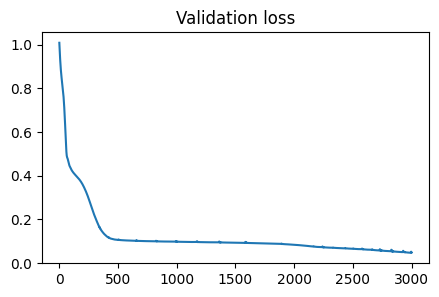

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

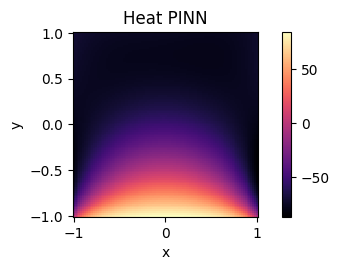

In [10]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heat PINN")
plt.tight_layout()
plt.axis("square")

### Helmholtz with k=2

In [12]:
num_points = 2000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-1, 1] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-1, 1] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 2000
k = 2
lr = 5e-4

In [13]:
pinn = PINN2D().to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 0.914
  200, 0.792
  300, 0.465
  400, 0.383
  500, 0.343
  600, 0.315
  700, 0.294
  800, 0.282
  900, 0.267
 1000, 0.255
 1100, 0.247
 1200, 0.240
 1300, 0.235
 1400, 0.229
 1500, 0.226
 1600, 0.221
 1700, 0.217
 1800, 0.215
 1900, 0.210
 1999, 0.210
 2000, 0.214


Text(0.5, 1.0, 'Validation loss')

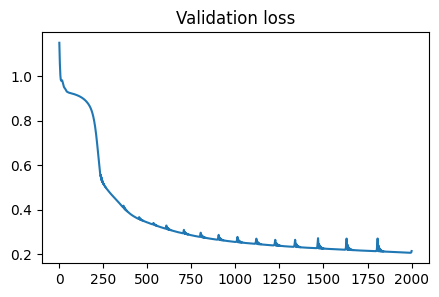

In [14]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

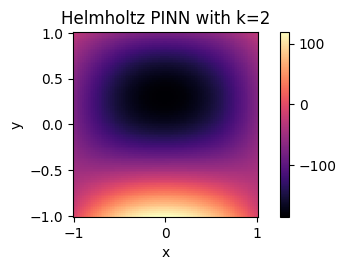

In [15]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Helmholtz PINN with k=2")
plt.tight_layout()
plt.axis("square")

### Helmholtz with k=2, extended plate

In [21]:
num_points = 8000 # define number of total points across the hot plate      num_points = 4000
border_coords = [-5, 5] # define [lower bound, upper bound] of hot plate    border_coords = [-5, 5]
temp_range = [-3, 3] # define [lower bound, upper bound] of temperatures    temp_range = [-2, 2]
epochs = 2000
k = 2
lr = 5e-4

In [25]:
pinn = PINN2D().to(device)
boundary_torch = torch.from_numpy(boundary).to(torch.float32).to(device)
collocation_torch = torch.from_numpy(collocation).to(torch.float32).to(device)
loss_list = pinn.train_pinn(boundary=boundary_torch, collocation=collocation_torch, n_epochs=epochs, lr=lr, k=k)

  100, 8.261
  200, 7.604
  300, 6.940
  400, 6.731
  500, 6.578
  600, 6.430
  700, 6.262
  800, 6.102
  900, 5.945
 1000, 5.746
 1100, 5.488
 1200, 5.303
 1300, 5.134
 1400, 4.966
 1500, 5.116
 1600, 4.673
 1700, 4.609
 1800, 4.674
 1900, 4.767
 1999, 4.401
 2000, 4.400


Text(0.5, 1.0, 'Validation loss')

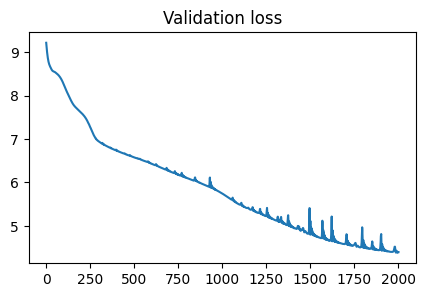

In [26]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), loss_list)
plt.title('Validation loss')

(-5.05050505050505, 5.05050505050505, -5.05050505050505, 5.05050505050505)

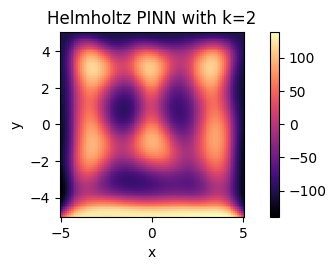

In [27]:
n = 100
X = np.linspace(border_coords[0], border_coords[1], n)
Y = np.linspace(border_coords[0], border_coords[1], n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = torch.from_numpy(X).to(torch.float32).to(device)
Y_T = torch.from_numpy(Y).to(torch.float32).to(device)
S = pinn.forward(X_T, Y_T)
S = S.detach().cpu().numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Helmholtz PINN with k=2")
plt.tight_layout()
plt.axis("square")